# 50 Years of Music Trends

## Objective
* Analyze lyrics from billboard top 100 songs over 50 years to identify trends
* Statement: Has the sentiments of popular lyrics changed over time?

## Hypothesis
* Ha = the sentiments of popular lyrics has become more negative over time
* Ho = no change in the sentiments of popular lyrics over time 

## Sources
* musixmatch source: https://developer.musixmatch.com/documentation/api-reference/track-lyrics-get <br/>
* musixmatch python: https://github.com/hudsonbrendon/python-musixmatch <br/>
* billboard python: https://github.com/guoguo12/billboard-charts<br/>

In [29]:
# Dependency library
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress

# API Calls
import billboard
from musixmatch import Musixmatch

# API Keys
from musixmatch_api import api_key

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Generate a (pseudo) random list of (almost all) dates in string format to fit musixmatch parameter

date_list = []
min_year = 1968
error_counter = 0

for i in range(50):
    try:
        # RANDOM date generation
        month_rand = str(random.randint(1,12))
        if len(month_rand) ==1:
            # PAD single digit numbers with a leading 0
            month_rand = month_rand.zfill(2)
            
        day_rand = str(random.randint(1,28))
        if len(day_rand) == 1:
            day_rand = day_rand.zfill(2)
        
        # STRINGIFY the result for the musixmatch parameter
        date_rand = str(f'{min_year}-{month_rand}-{day_rand}')
        
        # APPEND result to date_list
        date_list.append(date_rand)
        
        #INCREMENT the year
        min_year = min_year + 1
        
    except ValueError:
        error_counter = error_counter + 1

# VIEW date_list object
date_list

['1968-04-16',
 '1969-05-09',
 '1970-05-28',
 '1971-09-10',
 '1972-03-13',
 '1973-09-18',
 '1974-05-21',
 '1975-08-27',
 '1976-12-10',
 '1977-06-03',
 '1978-10-08',
 '1979-05-14',
 '1980-11-06',
 '1981-07-25',
 '1982-04-10',
 '1983-09-09',
 '1984-11-15',
 '1985-07-07',
 '1986-08-18',
 '1987-02-19',
 '1988-02-17',
 '1989-08-07',
 '1990-07-03',
 '1991-05-27',
 '1992-05-04',
 '1993-10-02',
 '1994-11-05',
 '1995-07-22',
 '1996-10-23',
 '1997-07-11',
 '1998-03-13',
 '1999-11-12',
 '2000-09-16',
 '2001-10-17',
 '2002-05-01',
 '2003-05-10',
 '2004-08-22',
 '2005-07-04',
 '2006-10-25',
 '2007-11-10',
 '2008-02-02',
 '2009-09-24',
 '2010-12-16',
 '2011-12-22',
 '2012-07-19',
 '2013-09-06',
 '2014-02-15',
 '2015-07-22',
 '2016-07-14',
 '2017-02-13']

In [3]:
# Return top 100 billboard songs for each date in random list generated above
# Note: Running this code takes approximately 2 minutes

billboard_list = 'hot-100'
col_names = ['Song','Artist','Date']
chart_df = pd.DataFrame(columns = col_names)

for date in date_list:
    chart = billboard.ChartData(billboard_list,date)
    for row in chart:
        # EMPTY the list placeholder used to create the dataframe
        chart_list = []
        # CLEAN and convert the billboard object
        chart_list.append(str(row).replace("'","",1))
        temp_df = pd.DataFrame(chart_list)
        temp_df = temp_df[0].str.split("' by ",expand=True)
        temp_df = temp_df.rename(columns={0:"Song",1:"Artist"})
        temp_df['Date'] = date
        
        # APPEND the temp_df in the current loop location to the chart_df
        chart_df = chart_df.append(temp_df)

# REMOVE duplicates and RESET index from the resulting dataframe        
chart_df = chart_df.drop_duplicates().reset_index(drop=True)

# VIEW dataframe head
print(len(chart_df))
chart_df.head()

5000


,Song,Artist,Date
0,Honey,Bobby Goldsboro,1968-04-16
1,Young Girl,The Union Gap Featuring Gary Puckett,1968-04-16
2,Cry Like A Baby,The Box Tops,1968-04-16
3,Lady Madonna,The Beatles,1968-04-16
4,(Sweet Sweet Baby) Since You've Been Gone,Aretha Franklin,1968-04-16


In [4]:
# SPLIT the date values in the dataframe for plotting and analysis purposes

chart_df['Year'], chart_df['Month'], chart_df['Day'] = chart_df['Date'].str.split('-').str

# VIEW dataframe head
chart_df.head()

,Song,Artist,Date,Year,Month,Day
0,Honey,Bobby Goldsboro,1968-04-16,1968,04,16
1,Young Girl,The Union Gap Featuring Gary Puckett,1968-04-16,1968,04,16
2,Cry Like A Baby,The Box Tops,1968-04-16,1968,04,16
3,Lady Madonna,The Beatles,1968-04-16,1968,04,16
4,(Sweet Sweet Baby) Since You've Been Gone,Aretha Franklin,1968-04-16,1968,04,16


In [5]:
# Retrieve lyrics from MusixMatch API based on song and artist in above dataframe
# Running this code takes approximately 5 - 7 minutes

musixmatch = Musixmatch(api_key)
lyrics_list = []
error_counter = 0

# LOOP through the data frame and use song title and artist name to search for lyrics in musixmatch
for x in range(len(chart_df)):
    
    # ERROR HANDLING in case a song queries returns 'null' from musixmatch
    try:
        # GRAB the lyrics based on location (iloc) in chart_df
        song_search = chart_df.iloc[x,0]
        artist_search = chart_df.iloc[x,1]
        lyrics = musixmatch.matcher_lyrics_get(q_artist=artist_search,
                                               q_track=song_search)['message']['body']['lyrics']['lyrics_body']
        
        # FORMATTING to truncate the nonsense at the end of the lyrics from MusixMatch
        song_length = len(lyrics)
        endpoint = len("******* This Lyrics is NOT for Commercial use *******\n(1409617829201)")
        lyrics = lyrics.replace("\n", " ")
        lyrics = str(lyrics[:song_length-endpoint])
        
        # APPEND lyrics to lyrics_list
        lyrics_list.append(lyrics)
        
    except:
        error_counter = error_counter + 1
        lyrics_list.append('MUSIXMATCH_NA')

# CREATE new column in chart_df
chart_df['Lyrics'] = lyrics_list

# VIEW dataframe head
chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,Honey,Bobby Goldsboro,1968-04-16,1968,04,16,"See the tree? how big it's grown, But friend, ..."
1,Young Girl,The Union Gap Featuring Gary Puckett,1968-04-16,1968,04,16,"Young Girl, Get Out Of My Mind My Love For You..."
2,Cry Like A Baby,The Box Tops,1968-04-16,1968,04,16,When I think about the good love you gave me I...
3,Lady Madonna,The Beatles,1968-04-16,1968,04,16,Lady Madonna Children at your feet Wonder how ...
4,(Sweet Sweet Baby) Since You've Been Gone,Aretha Franklin,1968-04-16,1968,04,16,Aretha Franklin Miscellaneous Sweet Sweet Baby...


In [12]:
# REMOVE blanks and errors from the dataframe
clean_chart_df = chart_df[chart_df['Lyrics'] != ("" or "MUSIXMATCH_NA")].reset_index(drop=True)

# VIEW dataframe head
clean_chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,Honey,Bobby Goldsboro,1968-04-16,1968,04,16,"See the tree? how big it's grown, But friend, ..."
1,Young Girl,The Union Gap Featuring Gary Puckett,1968-04-16,1968,04,16,"Young Girl, Get Out Of My Mind My Love For You..."
2,Cry Like A Baby,The Box Tops,1968-04-16,1968,04,16,When I think about the good love you gave me I...
3,Lady Madonna,The Beatles,1968-04-16,1968,04,16,Lady Madonna Children at your feet Wonder how ...
4,(Sweet Sweet Baby) Since You've Been Gone,Aretha Franklin,1968-04-16,1968,04,16,Aretha Franklin Miscellaneous Sweet Sweet Baby...
5,(Sittin' On) The Dock Of The Bay,Otis Redding,1968-04-16,1968,04,16,Sittin' in the morning sun I'll be sittin' whe...
6,The Ballad Of Bonnie And Clyde,Georgie Fame,1968-04-16,1968,04,16,Bonnie and Clyde were pretty looking people Bu...
7,Dance To The Music,Sly & The Family Stone,1968-04-16,1968,04,16,Cynthia: Get up and dance to the music! Get on...
8,Mighty Quinn (Quinn The Eskimo),Manfred Mann,1968-04-16,1968,04,16,"Come all without, come all within You'll not s..."
9,Scarborough Fair (/Canticle),Simon & Garfunkel,1968-04-16,1968,04,16,"Are you going to Scarborough Fair? Parsley, sa..."


In [15]:
# Vader Sentiment Analysis conducted on each song in the dataframe

# INITIALIZE a list to hold the sentiments
lyrics_sentiments = []

# ANALYZE the list
for y in range(len(clean_chart_df)):
    results = analyzer.polarity_scores(clean_chart_df.iloc[y,6])
    compound = results["compound"]
    pos = results["pos"]
    neu = results["neu"]
    neg = results["neg"]
    lyrics_sentiments.append({"Compound": compound,
                              "Positive": pos,
                              "Negative": neg,
                              "Neutral": neu})

# CREATE a dataframe of sentiment analysis that will be appended to the chart_df
lyrics_sentiments_df = pd.DataFrame(lyrics_sentiments)    
    
# APPEND new columns containing the sentiment analysis    
clean_chart_df['Compound'] = lyrics_sentiments_df['Compound']
clean_chart_df['Positive'] = lyrics_sentiments_df['Positive']
clean_chart_df['Negative'] = lyrics_sentiments_df['Negative']
clean_chart_df['Neutral'] = lyrics_sentiments_df['Neutral']

# SAVE to a .csv output
clean_chart_df.to_csv('billboard_analysis.csv')

# VIEW resulting dataframe head
clean_chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics,Compound,Positive,Negative,Neutral
0,Honey,Bobby Goldsboro,1968-04-16,1968,04,16,"See the tree? how big it's grown, But friend, ...",-0.1607,0.124,0.129,0.746
1,Young Girl,The Union Gap Featuring Gary Puckett,1968-04-16,1968,04,16,"Young Girl, Get Out Of My Mind My Love For You...",0.8750,0.189,0.000,0.811
2,Cry Like A Baby,The Box Tops,1968-04-16,1968,04,16,When I think about the good love you gave me I...,0.7842,0.288,0.226,0.486
3,Lady Madonna,The Beatles,1968-04-16,1968,04,16,Lady Madonna Children at your feet Wonder how ...,0.3527,0.052,0.025,0.923
4,(Sweet Sweet Baby) Since You've Been Gone,Aretha Franklin,1968-04-16,1968,04,16,Aretha Franklin Miscellaneous Sweet Sweet Baby...,0.9485,0.220,0.000,0.780


In [16]:
# Create the pandas dataframe group in order to calculate averages by year

chart_group = clean_chart_df.groupby(["Year"]).mean()
chart_group_df = pd.DataFrame(chart_group).reset_index(drop=False)
chart_group_df

,Year,Compound,Positive,Negative,Neutral
0,1968,0.446321,0.132524,0.041646,0.655073
1,1969,0.380180,0.145012,0.065434,0.705277
2,1970,0.439011,0.143593,0.054222,0.691136
3,1971,0.345675,0.117538,0.060125,0.697250
4,1972,0.423245,0.146349,0.054723,0.726590
5,1973,0.419199,0.140879,0.058857,0.723297
6,1974,0.448147,0.145888,0.061247,0.703034
7,1975,0.475566,0.153875,0.059337,0.686825
8,1976,0.432517,0.129586,0.042989,0.666483
9,1977,0.449613,0.128866,0.057196,0.690216


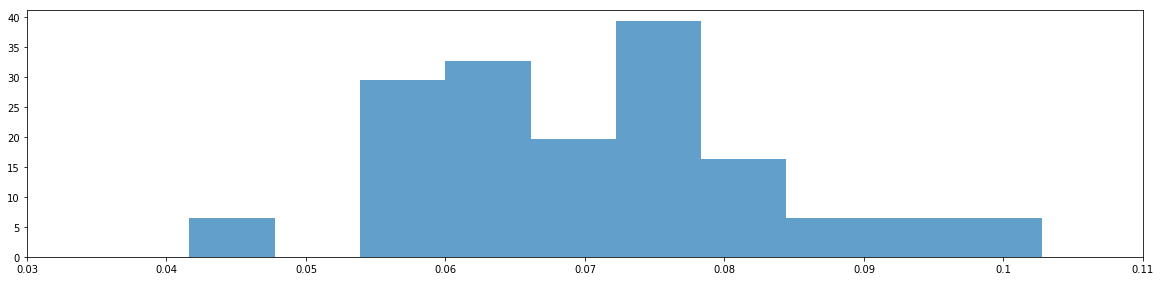

In [90]:
# TEST HISTOGRAM of negative sentiment results

plt.subplot(2, 1, 2)
plt.hist(chart_group_df['Negative'], 10, density=True, alpha=0.7, label="population1")
x,labels=plt.xticks()
labels=[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11]
plt.xticks(x,labels)
plt.xticks(label=labels)

plt.savefig("yourname_histogram.png")

In [91]:
# Create a local x-axis
x_axis = np.arange(1968,2018)
print(len(x_axis))
print(len(chart_group_df['Negative']))

50
50


r = 0.8032960724924272
r^2 = 0.6452845800817588
std err = 7.581275574021781e-05
p-value = 2.2215102621373104e-12
65% of the variation in the dependent variable (negative sentiment score) is accounted for by the variation in the independent variable (time in years). We feel comfortable using R^2, because the data is approximately normally distributed based on the shape of the histogram (slightly skewed right). Additionally, the p-value is 0+ which is < 0.05. Conclusion: We reject the null hypothesis (Ho) in favor of the alternative. These two variables are strongly related


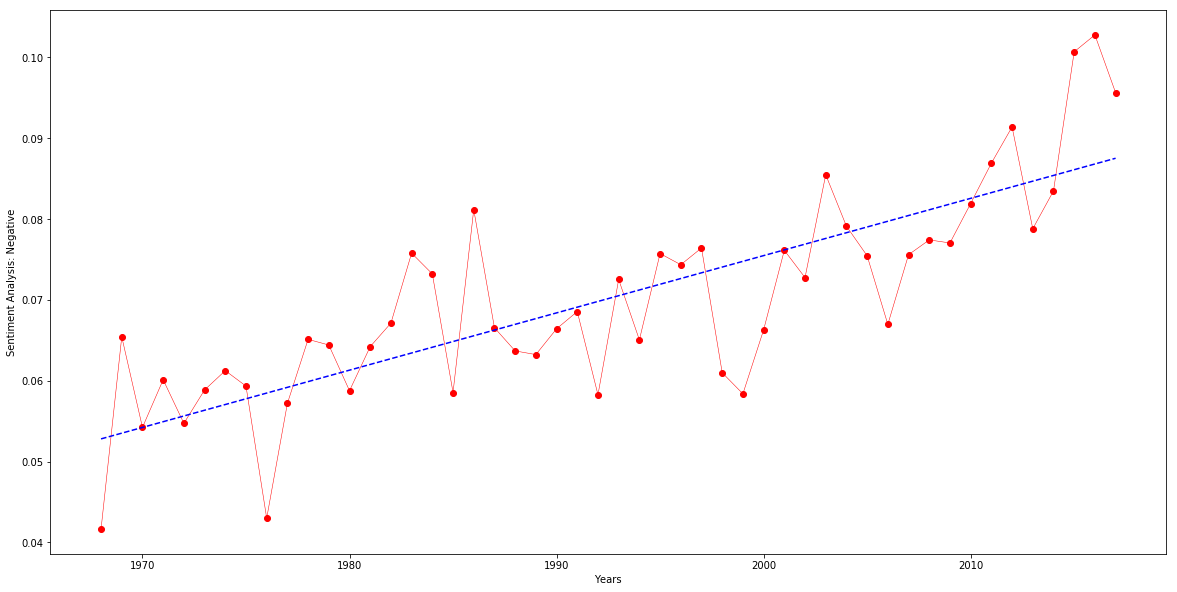

In [93]:
# Scatterplot of negative sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Negative'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots()
ax.set_xlabel("Years")
ax.set_ylabel("Sentiment Analysis: Negative")

# Plots the data
ax.plot(x_axis, chart_group_df['Negative'], marker='o', color=('red'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("yourname_negative.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')
print('65% of the variation in the dependent variable (negative sentiment score) is accounted for by the variation in the independent variable (time in years). We feel comfortable using R^2, because the data is approximately normally distributed based on the shape of the histogram (slightly skewed right). Additionally, the p-value is 0+ which is < 0.05. Conclusion: We reject the null hypothesis (Ho) in favor of the alternative. These two variables are strongly related')

r = -0.3455680112610224
r^2 = 0.11941725040689809
std err = 0.00012082224430921041
p-value = 0.013972232004561958


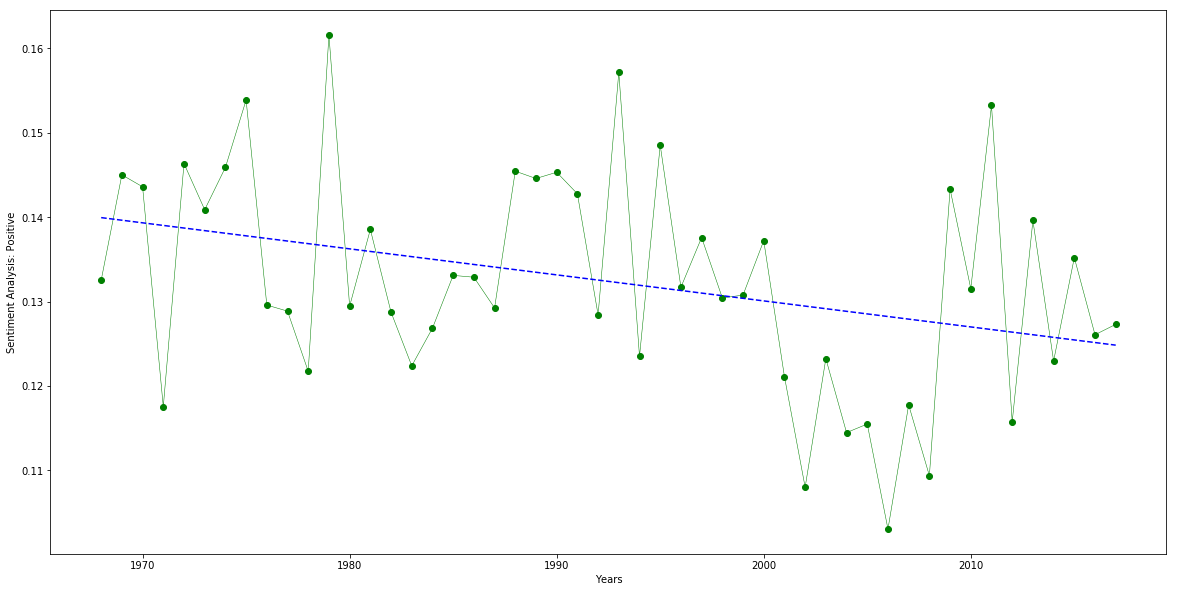

In [94]:
# Scatterplot of positive sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Positive'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots()
ax.set_xlabel("Years")
ax.set_ylabel("Sentiment Analysis: Positive")

# Plots the data
ax.plot(x_axis, chart_group_df['Positive'], marker='o', color=('green'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("yourname_positive.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')

r = 0.7692849253604941
r^2 = 0.591799296386901
std err = 0.0002581236373119602
p-value = 6.731858154501804e-11


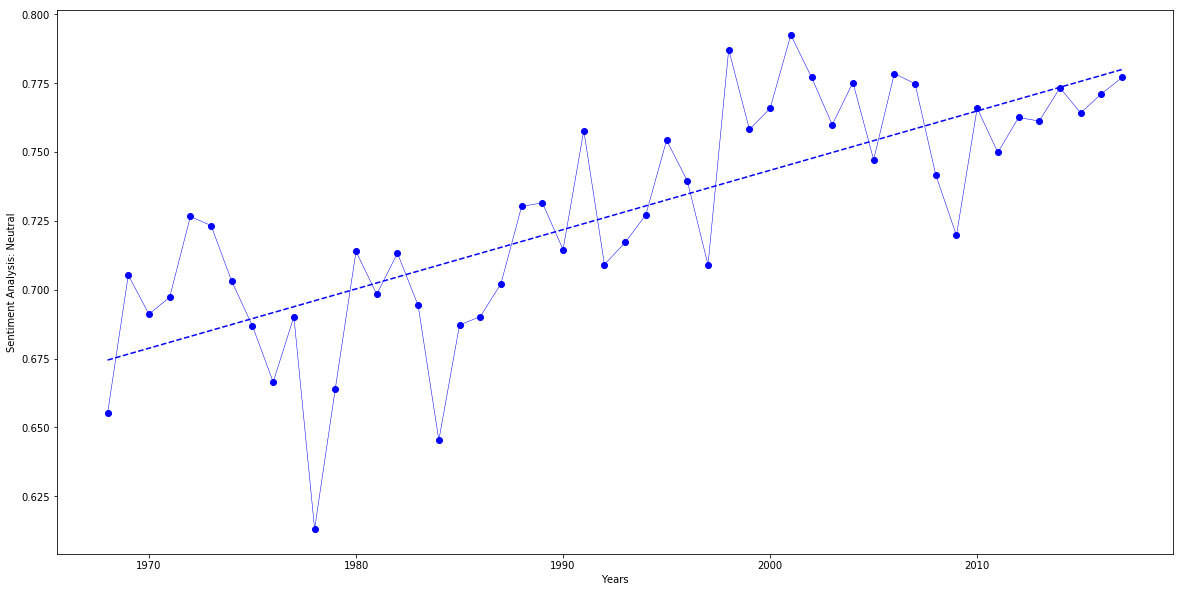

In [95]:
# Scatterplot of neutral sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Neutral'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots()
ax.set_xlabel("Years")
ax.set_ylabel("Sentiment Analysis: Neutral")

# Plots the data
ax.plot(x_axis, chart_group_df['Neutral'], marker='o', color=('blue'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("yourname_neutral.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')

r = -0.5857542232690096
r^2 = 0.34310801007748076
std err = 0.0006884801542510424
p-value = 7.868148633549058e-06


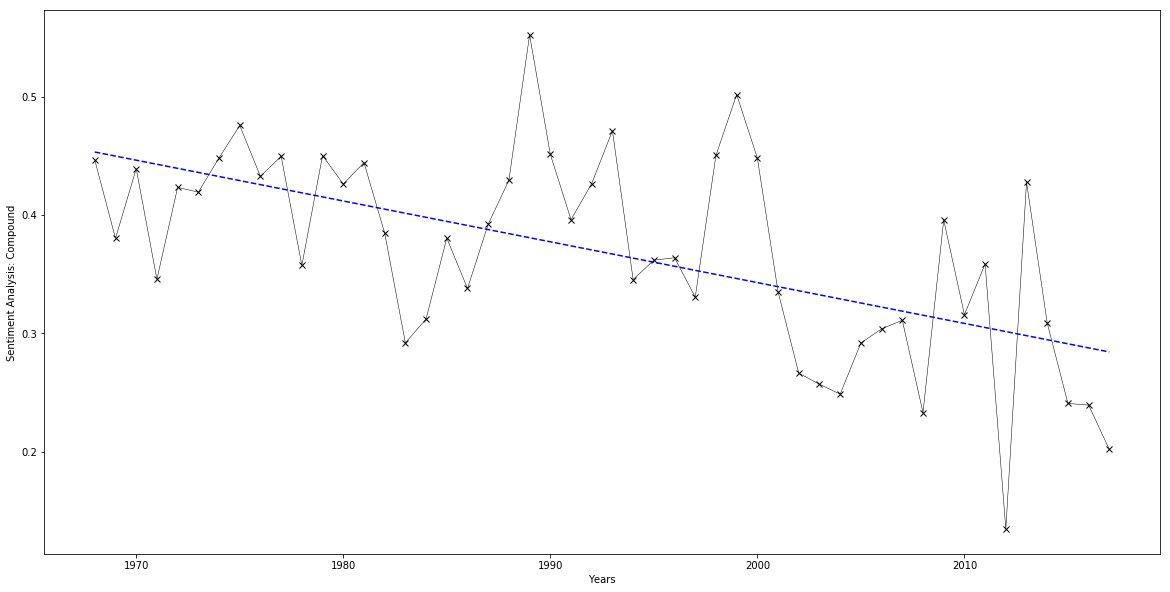

In [96]:
# Scatterplot of neutral sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Compound'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots()
ax.set_xlabel("Years")
ax.set_ylabel("Sentiment Analysis: Compound")

# Plots the data
ax.plot(x_axis, chart_group_df['Compound'], marker='x', color=('black'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("yourname_compound.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')